# Use Transfer Learning to Classify Pneumonia with Tensorflow

## Some imports 

In [1]:
import numpy as np
import os
import pathlib
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from PIL import Image
import IPython.display as display
from tqdm import tqdm
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Select the Hub/TF2 Module to Use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [2]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Loading the data

In [3]:
data_dir = pathlib.Path('../images')
image_count_train = len(list(data_dir.glob('train/*/*.jpeg')))
image_count_test = len(list(data_dir.glob('test/*/*.jpeg')))
image_count_val = len(list(data_dir.glob('val/*/*.jpeg')))
(image_count_test, image_count_train, image_count_val)

(487, 5216, 153)

In [4]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('train/*') if item.name != "LICENSE.txt"])
num_classes = len(CLASS_NAMES)
CLASS_NAMES

array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

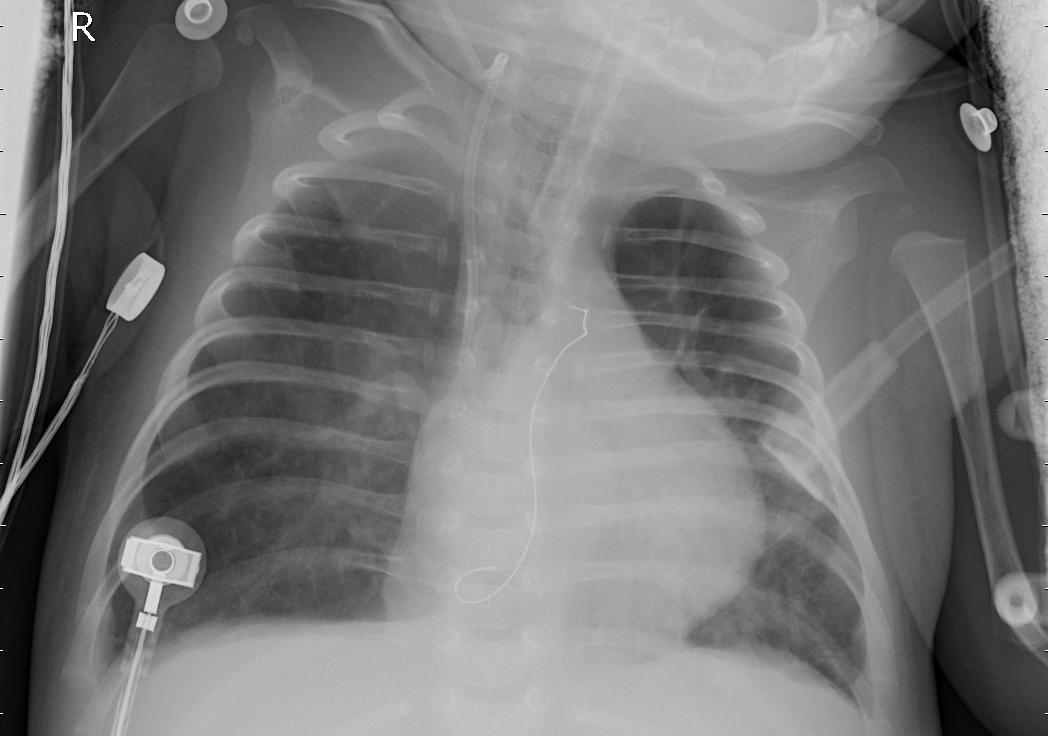

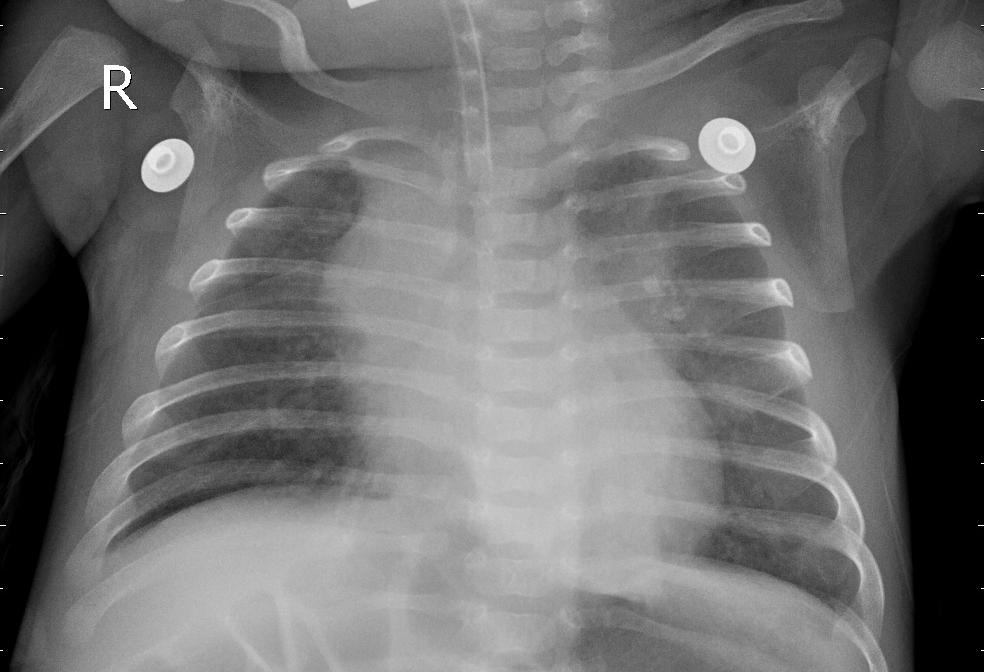

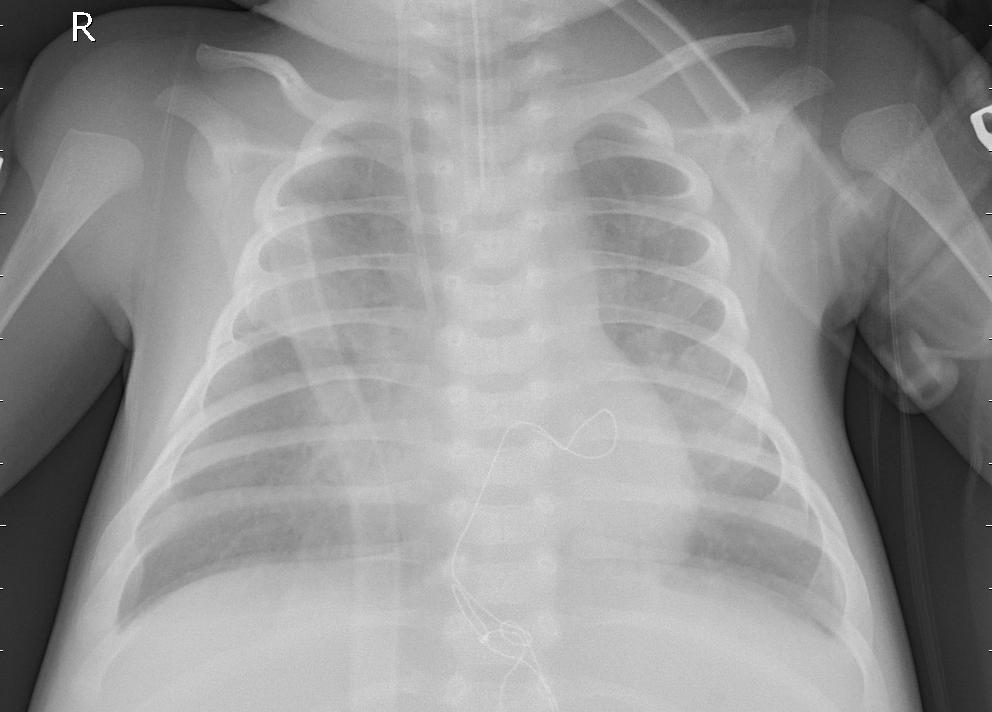

In [5]:
pneumonia = list(data_dir.glob('train/PNEUMONIA/*.jpeg'))

for image_path in pneumonia[:3]:
    display.display(Image.open(str(image_path)))


In [155]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
STEPS_PER_EPOCH = np.ceil(image_count_train/BATCH_SIZE)

In [156]:
test_ds = tf.data.Dataset.list_files(str(data_dir/'test/*/*'))
train_ds = tf.data.Dataset.list_files(str(data_dir/'train/*/*'))
val_ds = tf.data.Dataset.list_files(str(data_dir/'val/*/*'))

In [157]:
for f in test_ds.take(5):
  print(f.numpy())


b'../images/test/PNEUMONIA/person100_bacteria_481.jpeg'
b'../images/test/PNEUMONIA/person103_bacteria_488.jpeg'
b'../images/test/NORMAL/NORMAL2-IM-0267-0001.jpeg'
b'../images/test/PNEUMONIA/person1664_virus_2877.jpeg'
b'../images/test/PNEUMONIA/person174_bacteria_832.jpeg'


In [158]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return int(parts[-2] == CLASS_NAMES[0])


In [159]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


In [160]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [161]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]].title())
      plt.axis('off')


### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [162]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

In [163]:
train_examples = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_examples = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
validation_examples = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
for image, label in test_examples.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  0


In [164]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#   ds = ds.map(format_image)
  # Repeat forever
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [165]:
train_examples_dataset = prepare_for_training(train_examples)
test_examples_dataset = prepare_for_training(test_examples)
validation_examples_dataset = prepare_for_training(validation_examples)


image_batch, label_batch = next(iter(test_examples_dataset))



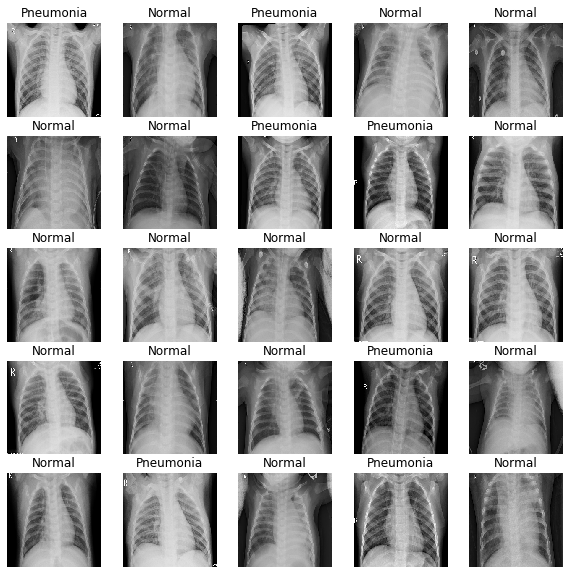

In [166]:
show_batch(image_batch.numpy(), label_batch.numpy())


## Defining the Model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [167]:
do_fine_tuning = False
do_not_train = False

Load TFHub Module

In [168]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=False)


## (Optional) Unfreeze some layers

In [169]:
print("Building model with", MODULE_HANDLE)

if do_fine_tuning:
    feature_extractor.trainable = True

else:
    feature_extractor.trainable = False

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4


In [170]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Training the Model

In [171]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [172]:
if not do_not_train:
    EPOCHS = 10

    hist = model.fit(train_examples_dataset,
                     epochs=EPOCHS,
                     steps_per_epoch=image_count_train/BATCH_SIZE,
                     validation_steps=np.floor(image_count_val/BATCH_SIZE),
                     validation_data=validation_examples_dataset)

Train for 163.0 steps, validate for 4.0 steps
Epoch 1/10
163/163 [==============================] - 119s 729ms/step - loss: 0.1763 - accuracy: 0.9329 - val_loss: 0.5172 - val_accuracy: 0.7734
Epoch 2/10
163/163 [==============================] - 124s 759ms/step - loss: 0.0879 - accuracy: 0.9724 - val_loss: 0.3647 - val_accuracy: 0.8594
Epoch 3/10
163/163 [==============================] - 122s 746ms/step - loss: 0.0723 - accuracy: 0.9785 - val_loss: 0.5053 - val_accuracy: 0.8281
Epoch 4/10
163/163 [==============================] - 91s 558ms/step - loss: 0.0619 - accuracy: 0.9799 - val_loss: 0.3148 - val_accuracy: 0.8828
Epoch 5/10
163/163 [==============================] - 100s 611ms/step - loss: 0.0582 - accuracy: 0.9822 - val_loss: 0.5734 - val_accuracy: 0.8047
Epoch 6/10
163/163 [==============================] - 93s 571ms/step - loss: 0.0518 - accuracy: 0.9831 - val_loss: 0.4610 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - 88s 538ms/step - loss: 0.0

## Export the Model

In [173]:
SAVED_MODEL = "pneumonia_saved_model"

Export the SavedModel

In [174]:
if not do_not_train:
    tf.saved_model.save(model, SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: pneumonia_saved_model/assets


INFO:tensorflow:Assets written to: pneumonia_saved_model/assets


In [175]:
%%bash -s $SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_7_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_7_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_15'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [176]:
loaded = tf.saved_model.load(SAVED_MODEL)

In [177]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_7_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_7_input')})
{'dense_15': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense_15')}


## Convert Using TFLite's Converter

Load the TFLiteConverter with the SavedModel

In [178]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)

### Post-Training Quantization
The simplest form of post-training quantization quantizes weights from floating point to 8-bits of precision. This technique is enabled as an option in the TensorFlow Lite converter. At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, hybrid operators dynamically quantize activations to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point, so that the speedup with hybrid ops is less than a full fixed-point computation.

In [179]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

### Post-Training Integer Quantization
We can get further latency improvements, reductions in peak memory usage, and access to integer only hardware accelerators by making sure all model math is quantized. To do this, we need to measure the dynamic range of activations and inputs with a representative data set. You can simply create an input data generator and provide it to our converter.

In [180]:
def representative_data_gen():
    for image_batch, label_batch in test_examples_dataset.take(1):
        for image in image_batch:
            yield [[image]]

In [181]:
def plot_representative_dataset(generator):
    plt.figure(figsize=(10,10))
    i = 1
    for image in generator:
        ax = plt.subplot(5,5,i)
        plt.imshow(image[0][0])
        plt.title(i)
        i += 1
        plt.axis('off')
        if i >= 26:
            break

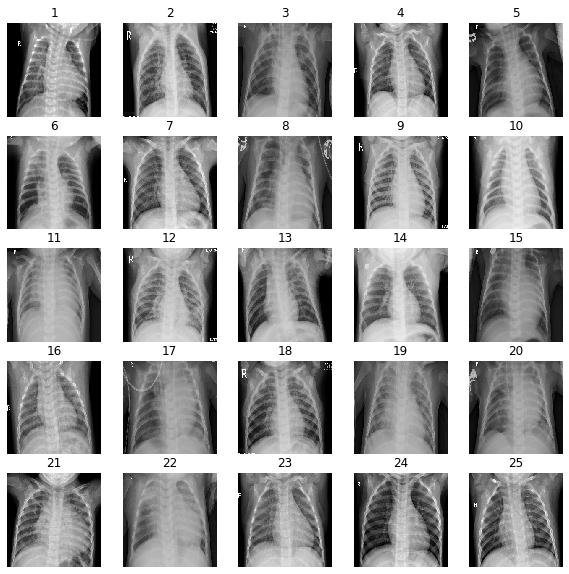

In [182]:
plot_representative_dataset(representative_data_gen())

In [183]:
len(list(representative_data_gen()))

32

In [184]:
converter.representative_dataset = representative_data_gen

The resulting model will be fully quantized but still take float input and output for convenience.

Ops that do not have quantized implementations will automatically be left in floating point. This allows conversion to occur smoothly but may restrict deployment to accelerators that support float. 

### Full Integer Quantization

To require the converter to only output integer operations, one can specify:

In [185]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

### Finally convert the model

In [186]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Test the TFLite Model Using the Python Interpreter

In [200]:
# Load TFLite model and allocate tensors.
  
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [201]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
print_all = 0
batch_num = 0
for image_batch, label_batch in iter(test_examples_dataset):
    batch_num += 1
    for img, label in zip(image_batch, label_batch):
        print_all += 1
        if print_all % 5 == 1:
            print(f'I am treating image {print_all} with label {label} and batch number {batch_num}')
        interpreter.set_tensor(input_index, np.array([img]))
        interpreter.invoke()
        predictions.append(interpreter.get_tensor(output_index))
        test_labels.append(label.numpy())
        test_imgs.append(img)
    if batch_num == 2:
        break

I am treating image 1 with label 1 and batch number 1
I am treating image 6 with label 1 and batch number 1
I am treating image 11 with label 1 and batch number 1
I am treating image 16 with label 1 and batch number 1
I am treating image 21 with label 0 and batch number 1
I am treating image 26 with label 0 and batch number 1
I am treating image 31 with label 0 and batch number 1
I am treating image 36 with label 0 and batch number 2
I am treating image 41 with label 0 and batch number 2
I am treating image 46 with label 1 and batch number 2
I am treating image 51 with label 1 and batch number 2
I am treating image 56 with label 0 and batch number 2
I am treating image 61 with label 0 and batch number 2
I am treating image 66 with label 1 and batch number 3
I am treating image 71 with label 1 and batch number 3
I am treating image 76 with label 0 and batch number 3


KeyboardInterrupt: 

In [203]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        
        color = 'green'
    else:
        color = 'red'
    
    plt.title("{} {:2.0f}% ({})".format(CLASS_NAMES[predicted_label],
                                         100*np.max(predictions_array),
                                         CLASS_NAMES[true_label]), color=color)

In [204]:
def plot_test_results():
    plt.figure(figsize=(15,15))
    for index in range(len(predictions)):
        if index+1 >= 26:
            break
        ax = plt.subplot(5,5,index+1)
        plot_image(index, predictions, test_labels, test_imgs)
        plt.axis('off')
plt.show()

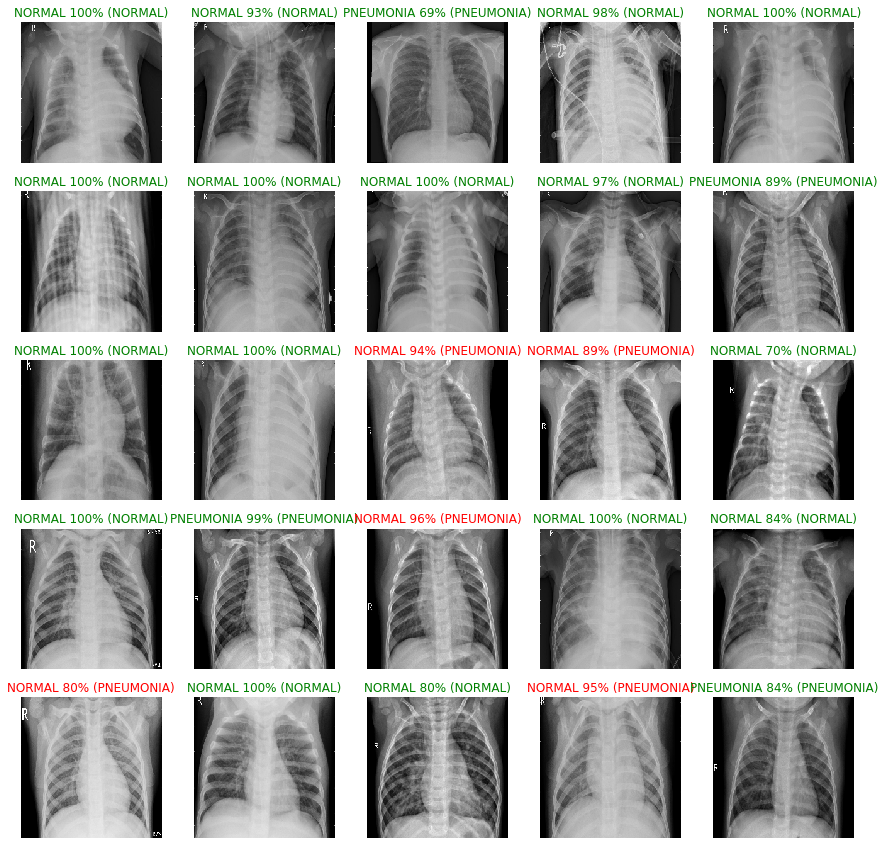

In [205]:
plot_test_results()

In [207]:
ok_value = 0
wrong_value = 0
true_positives = 0
total = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
for predictions_array, true_label in zip(predictions, test_labels):
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        ok_value += 1
        if CLASS_NAMES[true_label] == 'NORMAL':
            true_negatives += 1
        else:
            true_positives += 1
    else:
        wrong_value += 1
        if CLASS_NAMES[predicted_label] == 'NORMAL':
            false_negatives +=1
        else:
            false_positives += 1
    total += 1
print(f'Accuracy: {(true_positives + true_negatives) / total} \n ' \
      f'Sensitivity: {true_positives/ (true_positives + false_negatives)} \n ' \
      f'Specificity: {true_negatives / (true_negatives + false_positives)}')

Accuracy: 0.8026315789473685 
 Sensitivity: 0.5161290322580645 
 Specificity: 1.0


Create a file to save the labels.

In [208]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(CLASS_NAMES))